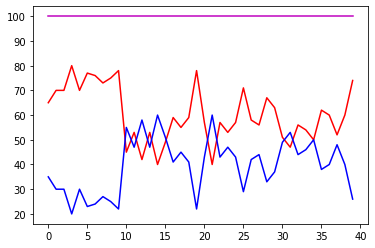

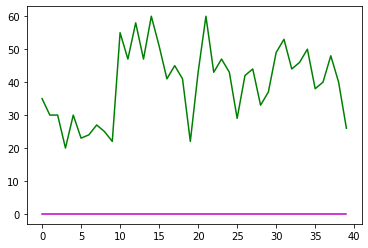

Wins for Final agent :  33
Wins for UCT agent :  0
Draws :  117


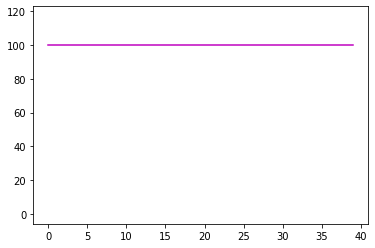

<Figure size 432x288 with 0 Axes>

In [1]:
# Written by Parastoo Azizinezhad
# pa19618@essex.ac.uk






# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Example GameState classes for Nim, OXO and Othello are included to give some idea of how you
# can write your own GameState use UCT in your 2-player game. Change the game to be played in 
# the UCTPlayGame() function at the bottom of the code.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 
# For more information about Monte Carlo Tree Search check out our web site at www.mcts.ai

from math import *
import random
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class GameState:
    """ A state of the game, i.e. the game board. These are the only functions which are
        absolutely necessary to implement UCT in any 2-player complete information deterministic 
        zero-sum game, although they can be enhanced and made quicker, for example by using a 
        GetRandomMove() function to generate a random move during rollout.
        By convention the players are numbered 1 and 2.
    """
    def __init__(self):
            self.playerJustMoved = 2 # At the root pretend the player just moved is player 2 - player 1 has the first move
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = GameState()
        st.playerJustMoved = self.playerJustMoved
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerJustMoved.
        """
        self.playerJustMoved = 3 - self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """

    def __repr__(self):
        """ Don't need this - but good style.
        """
        pass

class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is p2 - p1 has the first move
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == playerjm:
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []: return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self):
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]]
            if i % 3 == 2: s += "\n"
        return s

class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self):
        #return "["+str(self.move)+ str(self.wins)+ str(self.visits)+ str(self.untriedMoves)+"]"
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s


def UCT(Player, rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""


    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree

    
        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        
        while state.GetMoves() != []: # while state is non-terminal

            if Player != None : # 90-10 % moves using DT
              st = np.array(state.board,dtype='int32')
              st=st.reshape(1,9)
              premove = int(Player.predict(st))
              #print(premove)
              randmove = random.choice(state.GetMoves())
              finalmove = np.random.choice([premove, randmove], p=[0.9, 0.1])

              if finalmove in state.GetMoves():
                state.DoMove(finalmove)
              else :
                state.DoMove(random.choice(state.GetMoves()))


            else: #random move for the first stages without DT
              state.DoMove(random.choice(state.GetMoves()))

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - can be omitted
    if verbose:
        #print(rootnode.TreeToString(0))
        v = rootnode.TreeToString(0)
    else: 
        #print(rootnode.ChildrenToString())
        v = rootnode.ChildrenToString()     

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited
    # Can add ' v





# The Modified part
import numpy as np
import pandas as pd



def UCTPlayGame(agent1, agent2, itera ):
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    global win1
    global win2 
    global win0 



    movecount1 = 0
    movecount2 = 0
    currentplay = []
    statemove = []
    global trainset
    count = 0   


    state = OXOState() # uncomment to play OXO
    while state.GetMoves() != []:
        statemove = []
        #print(str(state))
        p = 3 - state.playerJustMoved
        if state.playerJustMoved == 1:
            m = UCT(agent1, rootstate=state, itermax=500, verbose=False)  # play with values for itermax and verbose = True
            movecount1 += 1 
        else:
            m = UCT(agent2,rootstate=state, itermax=100, verbose=False)
            movecount2 += 1
        statemove = list(state.board)
        statemove.append(int(m))
        currentplay.append(int(m))# append the values
        #print(statemove)
        trainset.append(statemove)
        state.DoMove(m)
        count += 1
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state))
            break
    if count < 9 :# Do this to make data frame nice
        for i in range (count, 9):# a single member is now 3
            currentplay.append(np.nan)

    if state.GetResult(state.playerJustMoved) == 1.0:
        win = int(state.playerJustMoved)
        #print("Player " + str(state.playerJustMoved) + " wins!")
        win1 += 1

    elif state.GetResult(state.playerJustMoved) == 0.0:
        win = int(3 - state.playerJustMoved)
        #print("Player " + str(3 - state.playerJustMoved) + " wins!")
        win2 +=1

    else: 
        win = 0
        win0 += 1
        #print("Nobody wins!")
    currentplay.append(win)
    #print(currentplay) # at the end of each game the winer will be added into the structure.
    datafull.append(currentplay)

def datagenerator(a,b,agent1,agent2,ngame):
  global win1
  global win2 
  global win0 
  global trainset
  global result
  #global agents
  win1 = 0
  win2 = 0
  win0 = 0
  trainset = []

  
  boardindex= ['0','1','2','3','4','5','6','7','8','Move']
  #movesindex =['S0 BM', 'S1 BM','S2 BM','S3 BM','S4 BM','S5 BM','S6 BM', 'S7 BM','S8 BM','The winner'] #dataset based on steps
  # generate dataset for each DT here
  for j in range (a,b): # number of data set generated
    for i in range (0, ngame): # number of game played
      #agents.append(str(j))
      UCTPlayGame(agent1=None, agent2=None, itera = 1000)

    filename = 'data_' + str(j) + '.csv'
    dftrain = pd.DataFrame(trainset, columns= boardindex)
    dftrain.to_csv(filename, sep=',',index=False)
    #df = pd.DataFrame(datafull, columns = movesindex)
    
    result.append([str(j),win0,win1,win2,(win1+win2),ngame])
    win1 = 0
    win2 = 0
    win0 = 0
    dftrain.dropna()



def PlayXOlevel2(a, b, ngame):
  global win1
  global win2 
  global win0 
  global trainset
  global result
  win1 = 0
  win2 = 0
  win0 = 0
  trainset = []

  
  global agents
  boardindex= ['0','1','2','3','4','5','6','7','8','Move']



  for j in range (a,b):
    #ag = str(j)
    filename = 'data_' + str(j) + '.csv'
    df= pd.read_csv(filename)
    Y=df['Move']
    Y=Y.astype(dtype='int32')
    X=df.drop(columns='Move')
    X=X.astype(dtype='int32')
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)
    agents.append(clf)


  #print (agents[0])
  #print (agents[2])

  
  for j in range (a,b): # number of data set generated
    for i in range (0, ngame): # number of game played
        k = b-j-1
        #print(k)
        ag1 = agents[j]
        ag2 = agents[k]
        UCTPlayGame(ag1,ag2, 1000)
        #print(i)
    filename = 'data_' + str(10+j) + '.csv'
    dftrain = pd.DataFrame(trainset, columns= boardindex)
    dftrain.to_csv(filename, sep=',',index=False)
    result.append([str(10+j),win0,win1,win2,(win1+win2),ngame])
    win1 = 0
    win2 = 0
    win0 = 0
    dftrain.dropna()

    #df = pd.DataFrame(datafull, columns = movesindex)

def specialgame():
  global win1
  global win2 
  global win0 
  global trainset
  global result
  win1 = 0
  win2 = 0
  win0 = 0
  trainset = []
  global agents
  boardindex= ['0','1','2','3','4','5','6','7','8','Move']

  for i in range (0, 150): # number of game played
    UCTPlayGame(agent1=agents[29], agent2=None, itera = 1000)
  filename = 'data_special.csv'
  dftrain = pd.DataFrame(trainset, columns= boardindex)
  dftrain.to_csv(filename, sep=',',index=False)
  #df = pd.DataFrame(datafull, columns = movesindex)
  print("Wins for Final agent : ", win1)
  print("Wins for UCT agent : ", win2)
  print("Draws : ", win0)
  dftrain.dropna()



  plt.plot(win1, color='r')
  plt.plot( win2, color='b')
  plt.plot( win0,  color='g')
  plt.plot(redf['Number of played game'], color = 'm')
  plt.show()
  plt.savefig('special.png')


agents=[]
result=[]
trainset = []
datafull =[]


if __name__ == "__main__":
  #redf.dropna()

  datagenerator(0,10,None,None,100) # generate 10 data set to train the first 10 agents
  PlayXOlevel2(0,10,100)
  PlayXOlevel2(10,20,100)
  PlayXOlevel2(20,30,100)


  redf = pd.DataFrame (result, columns = ['Dataset', 'Draw','Player1 wins','Player2 wins','Total win', 'Number of played game'])
  #redf
  redf.to_csv('results.csv', sep=',',index=False)

  #specialgame()

  plt.plot(redf['Draw'], color='r')
  plt.plot( redf['Total win'], color='b')
  #plt.plot( redf['Player2 wins'],  color='g')
  plt.plot(redf['Number of played game'], color = 'm')
  plt.show()
  plt.savefig('resultseprate.png')

  plt.plot(redf['Player1 wins'],  color='g')
  plt.plot(redf['Player2 wins'], color = 'm')
  plt.show()
  plt.savefig('onevstwo.png')
  specialgame()


  #movesindex =['S0 BM', 'S1 BM','S2 BM','S3 BM','S4 BM','S5 BM','S6 BM', 'S7 BM','S8 BM','The winner'] #dataset based on steps
  #fulldf = pd.DataFrame(datafull, columns = movesindex)
  #fulldf.toscv('fulldatamoves',sep=',', index = False)




In [0]:
  redf = pd.DataFrame (result, columns = ['Dataset', 'Draw','Player1 wins','Player2 wins','Total win', 'Number of played game'])
  #redf
  redf.to_csv('results.csv', sep=',',index=False)